## Spectral Radiance 
The spectral radiance is a radiometric wuantity that describes the amount of radiant energy emitted, reflected, transmitted, or received from a surface per unit solid angle, per unit projected area of the surface, and per unit wavelength or frequency interval.

**Planck's law** describes the spectral density of electromagnatic (EM) radiation $S(\lambda, T)$ of a certain wavelength $\lambda$ emitted by a black body in thermal equilibrium at a temperature $T$.  

$$ S(\lambda, T) = \frac{2 h c^2}{\lambda^5} \cdot \frac{1}{\exp\left(\tfrac{h c}{\lambda k T}\right) - 1} $$

- $S(\lambda, T)$: Spectral Radiance
- $h$: Planck constant,
- $c$: speed of light,
- $k$: Boltzmann constant,
- $T$: temperature (K),
- $\lambda$: wavelength (m)

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, k, pi

def planck_lambda(lmbd, T):
    """
    Planck's law: spectral radiance per wavelength [W / (m^3 sr)]
    lmbd: wavelength in m
    T: temperature in K
    
    Uses np.expm1 for better numerical stability without clipping.
    """
    x = (h * c) / (lmbd * k * T)
    return (2 * h * c**2 / lmbd**5) / np.expm1(x)

**Usage/Plot**

Below is an example usage of the "planck_lambda". It plots the spectral radiance for three different temperatures for a range of wavelengths in the infrared-(IR) Range.

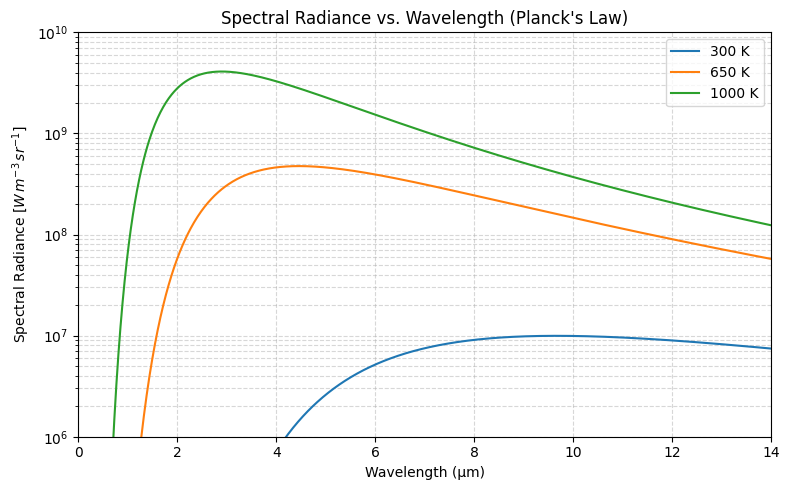

In [154]:
# Wavelengths from 0.1 to 14 micrometers, avoid zero to prevent division by zero, in meters
wavelength_um = np.linspace(0.1, 14, 1000)
wavelength_m = wavelength_um * 1e-6

temperatures = [300, 650, 1000]
labels = ["300 K", "650 K", "1000 K"]

plt.figure(figsize=(8, 5))
for T, label in zip(temperatures, labels):
    radiance = planck_lambda(wavelength_m, T)
    plt.plot(wavelength_um, radiance, label=label)

plt.xlabel("Wavelength (μm)")
plt.ylabel(r"Spectral Radiance $[W\,m^{-3}\,sr^{-1}]$")
plt.title("Spectral Radiance vs. Wavelength (Planck's Law)")
plt.yscale('log')
plt.ylim(1e6, 1e10)
plt.legend()
plt.xlim(0, 14)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.show()

## Band Radiance
Planck's law can be integrated over a band to obtain the band radiance. This is the total radiant power emitted by a black body within that specific wavelength range.

$$ L(\lambda_1, \lambda_2, T) = \int_{\lambda_1}^{\lambda_2} S(\lambda, T) \, d\lambda $$

- $L(\lambda_1, \lambda_2, T)$: Band radiance
- $\lambda_1, \lambda_2$: Band borders
- $S(\lambda, T)$: Spectral radiance
- $\lambda$: wavelength (m)

In [155]:
def integrate_band(T, lmbd_min, lmbd_max, n_samples=200):
    """
    Integrates Planck radiance over [lmbd_min, lmbd_max].
    Returns [W / (m^2 sr)].
    """
    wavelengths = np.linspace(lmbd_min, lmbd_max, n_samples)
    spectral = planck_lambda(wavelengths, T)
    return np.trapezoid(spectral, wavelengths)

## Atmospheric Transmission
When readiation passes through the atmosphere, it is attenuated. $\tau(\lambda)$ is the atmospheric transmission coefficient. It is simplified to be assummed constant for a small wavelength band $n$ (ex. MWIR/LWIR).
The formular for the measurable radiant power depends on the amount of times the EM-radiation passes through the atmosphere.

For a **one-way** path (ground -> satellite):
$$ L_{atm, ow}(n) = \tau(\lambda_n) \int_{\lambda_n}^{\lambda_{n+1}} S(\lambda, T) d\lambda $$
For a **two-way** path (sun -> ground -> satellite):
$$ L_{atm, tw}(n) = \tau(\lambda_n)^2 \int_{\lambda_n}^{\lambda_{n+1}} S(\lambda, T) d\lambda $$

- $L(n)$: Spectral Radiance (Measurable)
- $S(\lambda, T)$: Spectral Radiance
- $\tau(\lambda_n)$: Atmospheric transmission (constant for a band n)
- $\lambda_n$: Band Boarders

In [156]:
def band_power_with_atmos(T, band_edges, tau_spectrum, two_way):
    """
    Calculates band-integrated power per band with atmospheric transmission.

    T: temperature [K]
    band_edges: array of wavelength edges [m]
    tau_spectrum: array of tau values for each band (len = len(band_edges)-1)

    Returns: array of band powers [W / (m^2 sr)]
    """
    results = []
    for i in range(len(band_edges)-1):
        l0, l1 = band_edges[i], band_edges[i+1]
        raw_band = integrate_band(T, l0, l1)
        if two_way:
            attenuated = (tau_spectrum[i]**2) * raw_band
        else: 
            attenuated = tau_spectrum[i] * raw_band
        results.append(attenuated)
    return np.array(results)

## Aperture Consideration
When calculating the radiative power from a pixel area on the ground $A_\mathrm{px}$ that reaches the detector through an optical system, the optical transmission $\tau_{opt}$, detector efficiency $\alpha_\mathrm{det}$ and the aperture angle $\theta_\mathrm{ap}$ must be considered. The aperture limits the solid angle over which radiation is collected.

The following integral computes the pixel power $P_\mathrm{px}$ received by the detector, integrating Planck’s spectral radiance $S_\lambda(\lambda, T)$ over wavelength and the solid angle $\theta$ defined by the aperture, not accounting for atmospheric transmission. The solid angle is completed by the angle $\phi$, resulting in a cone stating from the surface of the black body. 

$$
    P_\mathrm{px} = A_\mathrm{px} \cdot \tau_\mathrm{opt} \cdot \alpha_\mathrm{det} \cdot \int_{\lambda_\mathrm{min}}^{\lambda_\mathrm{max}} S(\lambda, T) d\lambda
    \int_{0}^{2\pi} 
    \int_{0}^{\theta_{ap}} \cos\theta \sin\theta d\theta d\phi
$$

- $P_{px}$: Pixel Power
- $A_\mathrm{px}$: Pixel area on the ground
- $\tau_\mathrm{opt}$: Optical transmission (simplified to be constant for a band)
- $\alpha_\mathrm{det}$: Detector efficiency (simplified to be constant for a band)
- $[\lambda_\mathrm{min}, \lambda_\mathrm{max}]$: Band edges
- $\theta_{ap}$: Aperture half-angle
- $\phi$: Cone angle

The integration over the aperture can be performed analytically. For a circular aperture with half-angle $\theta_{ap}$ and Lambertian emission, integration over the solid angle yields a constant factor $\pi \sin^2(\theta_\mathrm{ap})$. Substituting results in a simplified formular:

$$
P_\mathrm{px} = A_\mathrm{px} \cdot \tau_\mathrm{opt} \cdot \alpha_\mathrm{det} \cdot \left[ \int_{\lambda_\mathrm{min}}^{\lambda_\mathrm{max}} S(\lambda, T)\; d\lambda \right] \cdot \pi \sin^2(\theta_\mathrm{ap})
$$

- $P_{px}$: Pixel Power
- $A_\mathrm{px}$: Pixel area on the ground
- $\tau_\mathrm{opt}$: Optical transmission (simplified to be constant for a band)
- $\alpha_\mathrm{det}$: Detector efficiency (simplified to be constant for a band)
- $[\lambda_\mathrm{min}, \lambda_\mathrm{max}]$: Band edges
- $\theta_{ap}$: Aperture half-angle

In [157]:
def pixel_power_aperture(T, lmbd_min, lmbd_max, theta_ap, A_px, tau_opt=0.9, alpha_det=0.9, n_samples=400):
    """
    Calculates pixel power received through an aperture.
    T: temperature [K]
    lmbd_min, lmbd_max: wavelength bounds [m]
    theta_ap: aperture half-angle [rad]
    A_px: pixel area [m^2]
    tau_opt: optical transmission
    alpha_det: detector efficiency
    """
    # Integrate Planck over wavelength
    wavelengths = np.linspace(lmbd_min, lmbd_max, n_samples)
    spectral = planck_lambda(wavelengths, T)
    I_band = np.trapezoid(spectral, wavelengths)  # [W / (m^2 sr)]

    # Integrate over solid angle defined by aperture
    Omega_ap = 2 * pi * (1 - np.cos(theta_ap))  # [sr]
    # For Lambertian source, radiance is weighted by cos(theta)
    solid_angle_factor = pi * (np.sin(theta_ap))**2  # ∫cosθ sinθ dθ dΦ over aperture

    # Total power
    P_px = A_px * tau_opt * alpha_det * I_band * solid_angle_factor
    return P_px

## Total Pixel-Power: Radiation, Albedo, Glint
The total power, reaching a pixel of a detector in space, looking at earth's surface is composed of three Components:

1. **Thermic emission of the Surface** $P_{surface}$

    The thermal radiation emitted by the Earth's surface itself due to its temperature.

2. **Reflected radiation from the sun (Albedo)** $P_{albedo}$

    The solar radiation incident on Earth's surface that is reflected back.

3. **Glint** $P_{glint}$

    A particular type of reflected sunlight characterized by a strong specular reflection, often from smooth water surfaces or other shiny surfaces, resulting in a bright reflection seen at a specific viewing angle.



The band radiance of each component is multiplied with the atmospheric and optical transmission coefficients $\tau_{n}$ and $\tau_{opt}$, the detector efficiency $\alpha_{det}$, the factor for the aperture half-angle $\pi \sin^2(\theta_\mathrm{ap})$ (warum nicht das: $2\pi(1-\cos\pi)$) and the pixel area on the surface $A_{px}$:

$$
P_\mathrm{px} = P_\mathrm{surface} + P_\mathrm{albedo} + P_\mathrm{glint}
$$

When the optical transmission of a detector is assumed constant in the observable range (high-quality detector) and the atmospheric radiance is simplified to be constant for a band, the following formular describes the power reaching a pixel for a group of $n$ bands (ex. MWIR & LWIR), for a **one-way** path:

$$
P_\mathrm{Band,\,total,\,ow} = A_\mathrm{px} \cdot \tau_\mathrm{opt} \cdot \alpha_\mathrm{det} \cdot \left[ \sum_{n=1}^{N} \tau_n \cdot \int_{\lambda_n}^{\lambda_{n+1}} S_\lambda(\lambda, T)\, d\lambda \right]\cdot \pi \sin^2(\theta_\mathrm{ap}) \cdot a
$$

And for a **two-way** path:

$$
P_\mathrm{Band,\,total,\,tw} = A_\mathrm{px} \cdot \tau_\mathrm{opt} \cdot \alpha_\mathrm{det} \cdot \left[ \sum_{n=1}^{N} \tau_n^2 \cdot \int_{\lambda_n}^{\lambda_{n+1}} S_\lambda(\lambda, T)\, d\lambda  \right] \cdot \pi \sin^2(\theta_\mathrm{ap}) \cdot a
$$

- $P_{px}$: Pixel Power
- $A_\mathrm{px}$: Pixel area on the ground
- $\tau_\mathrm{n}$: Atmospheric Transmission (simplified to be constant for a band)
- $\tau_\mathrm{opt}$: Optical transmission (simplified to be constant for the measurable wavelengths)
- $\alpha_\mathrm{det}$: Detector efficiency (simplified to be constant for the measurable wavelengths)
- $[\lambda_\mathrm{n}, \lambda_\mathrm{n+1}]$: Band edges
- $\theta_{ap}$: Aperture half-angle
- $n$: Band number
- $a$: Constant factor

**Components**
- **Surface Emission** 

    the one-way equation can be multiplied with the surface's emissivity $\epsilon_{ground}$.

    $
    P_\mathrm{surface} = A_\mathrm{px} \cdot \tau_\mathrm{opt} \cdot \alpha_\mathrm{det} \cdot \epsilon_{ground} \cdot \left[ \sum_{n=1}^{N} \tau_n \cdot \int_{\lambda_n}^{\lambda_{n+1}} S_\lambda(\lambda, T)\, d\lambda \right]\cdot \pi \sin^2(\theta_\mathrm{ap}) 
    $

- **Albedo**

    In the worst canse scenario (the satellite and sun are in one line) the emission from the sun's surface is directly scattered by earth's surface. The radiation is calculated with Planck's law and the surface temperature of the sun, however a geometrical correction factor $G$ (projects the radiation of the sun's surface to a spherical surface with the radius of the distance between sun and earth) is introduced and multiplied with the universal two-way equation

    As most surfaces on earth are not only reflecting but also transmitting and absorbing, a reduction factor $\rho_{alb}$ is introduced.

    $G=\frac{r_{sun}^2}{d_{sun - earth}^2}$

    $P_\mathrm{albedo} = A_\mathrm{px} \cdot \tau_\mathrm{opt} \cdot \alpha_\mathrm{det} \cdot G \cdot \rho_{alb} \cdot \left[ \sum_{n=1}^{N} \tau_n^2 \cdot \int_{\lambda_n}^{\lambda_{n+1}} S_\lambda(\lambda, T_{sun})\, d\lambda  \right] \cdot \pi \sin^2(\theta_\mathrm{ap})$

- **Glint** 

    It is assumed that glint is a specular reflection of the sun on the surface of the earth and that it only reaches the imager when the sun is directly behind the imager. The effect is simplified to directly come from the sun's surface to the sensor ($d_{imager - earth} << d_{sun - earth}$). Again the radiation is calculated with Planck's law and the surface temperature of the sun.

    The largest surfaces that produce sun glint is water. The relation of reflection $\rho_{wat}$ is dependent on the refractive indixes of air $m_1$ and water $m_2$.

    $\rho_{wat} = (\frac{m_1 - m_2}{m_1 + m_2})^2$

    The relation of reflection and the ratio of the surface covered by $\delta_{glint}$ can now be multiplied with the universal formular for a two-way path.

    $P_\mathrm{Band,\,total,\,tw} = A_\mathrm{px} \cdot \tau_\mathrm{opt} \cdot \alpha_\mathrm{det} \cdot \delta_{glint} \cdot \rho_{wat} \cdot \left[ \sum_{n=1}^{N} \tau_n^2 \cdot \int_{\lambda_n}^{\lambda_{n+1}} S_\lambda(\lambda, T_{sun})\, d\lambda  \right] \cdot \pi \sin^2(\theta_\mathrm{ap})$


In [158]:
def generic_band_power(band_edges, tau_atm_band, tau_ap, alpha_det, T_surface, two_way, area: float, theta_ap: float, factor, n_samples):
    powers = []
    for i in range(len(band_edges)-1):
        # integrate a band
        l0,l1 = band_edges[i], band_edges[i+1];
        I_band = integrate_band(T_surface, l0, l1, n_samples);
        # pixel area on the ground, detector efficiency, optical transmission, apeture factor
        P_temp = I_band * area * alpha_det * tau_ap * pi* (np.sin(theta_ap)**2);
        # atmospheric transmission
        if two_way:
            P_temp = P_temp * (tau_atm_band[i]**2);
        else:
            P_temp = P_temp * tau_atm_band[i];
        # constant prefactor
        P_band = P_temp * factor;
        powers.append(P_band);

    powers = np.array(powers)
    return powers, powers.sum()

**Mock-Atmosphere/Usage/Plot**

The following programm uses the "generic_band_power" function to simulate the atmospheric transmission spectrum with an absorption dip around 4.3um (CO_2 band).

In [159]:
# --- Mock spectrum setup ---
T_ground = 300.0
lmbd_min, lmbd_max = 3e-6, 5e-6

# Divide band into sub-bands (e.g. 30 channels)
n_bands = 30
band_edges = np.linspace(lmbd_min, lmbd_max, n_bands+1)

# Mock transmission: Gaussian dip around 4.3 µm (CO2 absorption)
band_centers = 0.5*(band_edges[:-1] + band_edges[1:])
tau_mock = 0.8 - 0.5*np.exp(-((band_centers - 4.3e-6)**2)/(0.1e-6)**2)

# Compute band powers
# Parameter
delta_glint = 0.00 # Glint factor (assumed for simplicity)
T_sun = 5777.0
rho_albedo = 0.03
tau_opt = 0.5
alpha_det = 0.8
D = 0.06         # [m]
d = 600e3        # [m]
theta_ap = 0.5 * D / d  # [rad]
GSD = 200 # [m]
A_px = GSD**2         # Pixel area on earths [m^2]

# Boden-Emission
P_ground_band, P_ground_total = generic_band_power(band_edges, tau_mock, tau_opt, alpha_det, T_ground, False, A_px, theta_ap, 1.0, 400);

# Albedo (reflektierte Solarleistung)
geom = (6.9634e8**2) / (1.5e11**2)
P_albedo_band, P_albedo_total = generic_band_power(band_edges, tau_mock, tau_opt, alpha_det, T_sun, True, A_px, theta_ap, geom * rho_albedo, 400);

# Glint (vereinfachte Annahme: wie Albedo, aber mit delta_glint als Faktor)
rho_wat = 0.02
P_glint_band, P_glint_total = generic_band_power(band_edges, tau_mock, tau_opt, alpha_det, T_sun, True, A_px, theta_ap, delta_glint * rho_wat, 400);

# Gesamtsumme
P_total_band = P_ground_band + P_albedo_band + P_glint_band
P_total = P_total_band.sum()

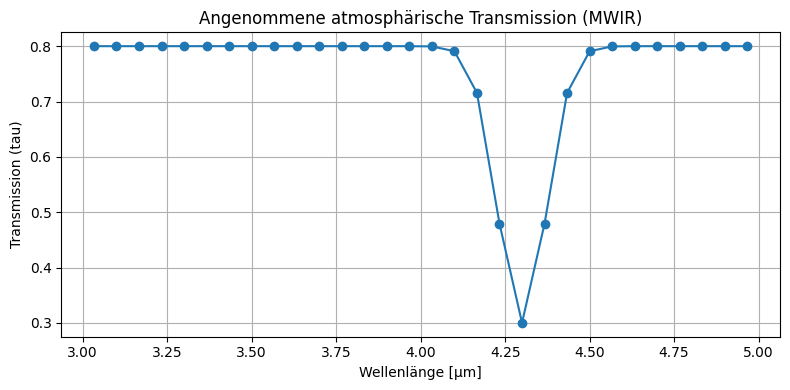

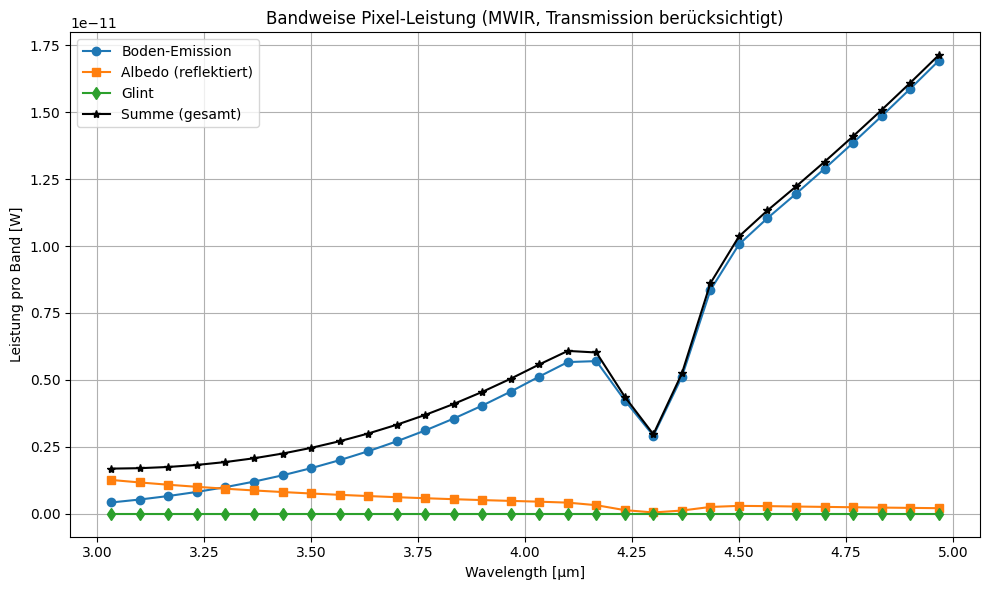

In [160]:
plt.figure(figsize=(8,4))
plt.plot(band_centers * 1e6, tau_mock, 'o-', color='tab:blue')
plt.xlabel('Wellenlänge [µm]')
plt.ylabel('Transmission (tau)')
plt.title('Angenommene atmosphärische Transmission (MWIR)')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.plot(band_centers * 1e6, P_ground_band, 'o-', label='Boden-Emission')
plt.plot(band_centers * 1e6, P_albedo_band, 's-', label='Albedo (reflektiert)')
plt.plot(band_centers * 1e6, P_glint_band, 'd-', label='Glint')
plt.plot(band_centers * 1e6, P_total_band, 'k*-', label='Summe (gesamt)')

plt.xlabel('Wavelength [µm]')
plt.ylabel('Leistung pro Band [W]')
plt.title('Bandweise Pixel-Leistung (MWIR, Transmission berücksichtigt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()